# Config

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Configs
class CFG:
    #Random seed
    SEED = 333333
    BASE = os.getcwd()
    splits = 5

# Libs

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import random
import os
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import mean_absolute_error, roc_auc_score, roc_curve

import pandas as pd
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Set seed
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    print('seeding done!!!')
set_seed(CFG.SEED)

seeding done!!!


In [3]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [4]:
columns_to_keep = ['CIDs', 'BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v',
                   'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
                   'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
                   'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
                   'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
                   'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
                   'fr_COO', 'fr_COO2', 'EC1_EC2_EC3_EC4_EC5_EC6']



In [5]:
df = pd.read_csv(CFG.BASE + '/train.csv')
test = pd.read_csv(CFG.BASE + '/test.csv')

df.shape , test.shape

((14838, 38), (9893, 32))

In [6]:
df.head()

id     BertzCT       Chi1     Chi1n      Chi1v     Chi2n      Chi2v  \
0   0  323.390782   9.879918  5.875576   5.875576  4.304757   4.304757   
1   1  273.723798   7.259037  4.441467   5.834958  3.285046   4.485235   
2   2  521.643822  10.911303  8.527859  11.050864  6.665291   9.519706   
3   3  567.431166  12.453343  7.089119  12.833709  6.478023  10.978151   
4   4  112.770735   4.414719  2.866236   2.866236  1.875634   1.875634   

      Chi3v     Chi4n  EState_VSA1  ...  SlogP_VSA3  VSA_EState9  fr_COO  \
0  2.754513  1.749203     0.000000  ...    4.794537    35.527357       0   
1  2.201375  1.289775    45.135471  ...   13.825658    44.707310       0   
2  5.824822  1.770579    15.645394  ...   17.964475    45.660120       0   
3  7.914542  3.067181    95.639554  ...   31.961948    87.509997       0   
4  1.036450  0.727664    17.980451  ...    9.589074    33.333333       2   

   fr_COO2  EC1  EC2  EC3  EC4  EC5  EC6  
0        0    1    1    0    0    0    0  
1        0    0    1    1    0    0    0  
2        0    1    1    0    0    1    0  
3        0    1    1    0    0    0    0  
4        2    1    0    1    1    1    0  

[5 rows x 38 columns]

In [7]:
df.info(max_cols = df.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 14838 non-null  int64  
 1   BertzCT            14838 non-null  float64
 2   Chi1               14838 non-null  float64
 3   Chi1n              14838 non-null  float64
 4   Chi1v              14838 non-null  float64
 5   Chi2n              14838 non-null  float64
 6   Chi2v              14838 non-null  float64
 7   Chi3v              14838 non-null  float64
 8   Chi4n              14838 non-null  float64
 9   EState_VSA1        14838 non-null  float64
 10  EState_VSA2        14838 non-null  float64
 11  ExactMolWt         14838 non-null  float64
 12  FpDensityMorgan1   14838 non-null  float64
 13  FpDensityMorgan2   14838 non-null  float64
 14  FpDensityMorgan3   14838 non-null  float64
 15  HallKierAlpha      14838 non-null  float64
 16  HeavyAtomMolWt     148

In [8]:
df.describe(include='all').T

count         mean          std         min          25%  \
id                 14838.0  7418.500000  4283.505982    0.000000  3709.250000   
BertzCT            14838.0   515.153604   542.456370    0.000000   149.103601   
Chi1               14838.0     9.135189     6.819989    0.000000     4.680739   
Chi1n              14838.0     5.854307     4.647064    0.000000     2.844556   
Chi1v              14838.0     6.738497     5.866444    0.000000     2.932842   
Chi2n              14838.0     4.432570     3.760516    0.000000     1.949719   
Chi2v              14838.0     5.253221     4.925065    0.000000     2.034468   
Chi3v              14838.0     3.418749     3.436208    0.000000     1.160763   
Chi4n              14838.0     1.773472     1.865898    0.000000     0.503897   
EState_VSA1        14838.0    29.202823    31.728679    0.000000     5.969305   
EState_VSA2        14838.0    10.435316    13.651843    0.000000     0.000000   
ExactMolWt         14838.0   292.623087   225.384140    1.007276   148.037173   
FpDensityMorgan1   14838.0     1.236774     5.491284 -666.000000     1.045455   
FpDensityMorgan2   14838.0     1.812070     5.495565 -666.000000     1.690909   
FpDensityMorgan3   14838.0     2.255470     5.501200 -666.000000     2.100000   
HallKierAlpha      14838.0    -1.207776     0.935314   -7.730000    -1.660000   
HeavyAtomMolWt     14838.0   274.950211   212.678755    0.000000   136.109000   
Kappa3             14838.0     5.874372    45.730226 -104.040000     1.784008   
MaxAbsEStateIndex  14838.0    10.556443     1.559331    0.000000     9.926190   
MinEStateIndex     14838.0    -2.119772     2.066415   -6.327514    -4.659604   
NumHeteroatoms     14838.0     8.584108     7.643769    0.000000     4.000000   
PEOE_VSA10         14838.0    11.021644    13.958962    0.000000     0.000000   
PEOE_VSA14         14838.0    17.790011    34.561655    0.000000     0.000000   
PEOE_VSA6          14838.0     8.962440    19.756727    0.000000     0.000000   
PEOE_VSA7          14838.0    11.318811    20.169745    0.000000     0.000000   
PEOE_VSA8          14838.0     6.704487    10.865415    0.000000     0.000000   
SMR_VSA10          14838.0    15.666766    18.080208    0.000000     5.969305   
SMR_VSA5           14838.0    31.066423    33.896638    0.000000     6.420822   
SlogP_VSA3         14838.0    13.636941    14.598554    0.000000     4.794537   
VSA_EState9        14838.0    49.309959    29.174824   -5.430556    30.000000   
fr_COO             14838.0     0.458215     0.667948    0.000000     0.000000   
fr_COO2            14838.0     0.459226     0.668111    0.000000     0.000000   
EC1                14838.0     0.667745     0.471038    0.000000     0.000000   
EC2                14838.0     0.798962     0.400790    0.000000     1.000000   
EC3                14838.0     0.313789     0.464047    0.000000     0.000000   
EC4                14838.0     0.279081     0.448562    0.000000     0.000000   
EC5                14838.0     0.144831     0.351942    0.000000     0.000000   
EC6                14838.0     0.151570     0.358616    0.000000     0.000000   

                           50%           75%           max  
id                 7418.500000  11127.750000  14837.000000  
BertzCT             290.987941    652.652585   4069.959780  
Chi1                  6.485270     11.170477     69.551167  
Chi1n                 4.052701      7.486791     50.174588  
Chi1v                 4.392859      8.527859     53.431954  
Chi2n                 2.970427      5.788793     32.195368  
Chi2v                 3.242775      6.609350     34.579313  
Chi3v                 1.948613      4.502070     22.880836  
Chi4n                 1.073261      2.534281     16.072810  
EState_VSA1          17.353601     44.876559    363.705954  
EState_VSA2           6.420822     12.841643     99.936429  
ExactMolWt          206.042653    343.090331   2237.318490  
FpDensityMorgan1      1.250000      1.500000      3.000000  
FpDensi

In [9]:
test.describe(include ='all').T

count          mean          std           min  \
id                 9893.0  19784.000000  2856.007440  14838.000000   
BertzCT            9893.0    516.411916   544.327795      0.000000   
Chi1               9893.0      9.106998     6.754583      0.000000   
Chi1n              9893.0      5.848047     4.641662      0.000000   
Chi1v              9893.0      6.733659     5.863886      0.000000   
Chi2n              9893.0      4.428979     3.770031      0.000000   
Chi2v              9893.0      5.247994     4.939702      0.000000   
Chi3v              9893.0      3.401083     3.431766      0.000000   
Chi4n              9893.0      1.750078     1.837159      0.000000   
EState_VSA1        9893.0     28.956335    31.470865      0.000000   
EState_VSA2        9893.0     10.534500    13.768117      0.000000   
ExactMolWt         9893.0    292.006497   224.667454     15.007276   
FpDensityMorgan1   9893.0      1.280917     0.361229     -1.133333   
FpDensityMorgan2   9893.0      1.861792     0.348650      0.416667   
FpDensityMorgan3   9893.0      2.304095     0.382551      0.361111   
HallKierAlpha      9893.0     -1.206781     0.923173     -7.620000   
HeavyAtomMolWt     9893.0    274.583106   212.321052     14.007000   
Kappa3             9893.0      5.280890    37.349006   -104.040000   
MaxAbsEStateIndex  9893.0     10.555415     1.572745      0.000000   
MinEStateIndex     9893.0     -2.098765     2.059608     -6.117075   
NumHeteroatoms     9893.0      8.590215     7.660447      0.000000   
PEOE_VSA10         9893.0     11.033200    13.905575      0.000000   
PEOE_VSA14         9893.0     18.493154    35.832279      0.000000   
PEOE_VSA6          9893.0      8.917260    19.358857      0.000000   
PEOE_VSA7          9893.0     11.222822    20.015732      0.000000   
PEOE_VSA8          9893.0      6.789234    10.778071      0.000000   
SMR_VSA10          9893.0     15.810550    18.265549      0.000000   
SMR_VSA5           9893.0     30.919849    33.532665      0.000000   
SlogP_VSA3         9893.0     13.601593    14.689893      0.000000   
VSA_EState9        9893.0     49.426755    29.542758     -5.061146   
fr_COO             9893.0      0.459719     0.676657      0.000000   
fr_COO2            9893.0      0.461235     0.677194      0.000000   

                            25%           50%           75%           max  
id                 17311.000000  19784.000000  22257.000000  24730.000000  
BertzCT              150.255712    289.901774    652.758463   3919.541449  
Chi1                   4.698377      6.447265     10.966946     53.876516  
Chi1n                  2.846050      4.009996      7.490880     43.283925  
Chi1v                  2.934030      4.337841      8.528316     53.990574  
Chi2n                  1.949719      2.930013      5.788793     36.368883  
Chi2v                  2.049137      3.168052      6.516914     44.726398  
Chi3v                  1.171060      1.923982      4.302610     26.736931  
Chi4n                  0.508512      1.058931      2.509394     15.620667  
EState_VSA1            5.969305     17.282269     44.876559    363.705954  
EState_VSA2            0.000000      6.420822     12.841643     99.936429  
ExactMolWt           148.073559    206.021523    342.116212   1888.793611  
FpDensityMorgan1       1.043478      1.250000      1.500000      3.000000  
FpDensityMorgan2       1.692308      1.866667      2.071429      3.200000  
FpDensityMorgan3       2.100000      2.358491      2.520000      3.375000  
HallKierAlpha         -1.680000     -1.100000     -0.570000      0.830000  
HeavyAtomMolWt       140.050000    194.125000    320.121000   1758.846000  
Kappa3                 1.788507      3.261011      5.772640   1512.242231  
MaxAbsEStateIndex      9.946009     10.418624     11.526326     14.630251  
MinEStateIndex        -4.638889     -1.252751     -0.787037      4.750000  
NumHeteroatoms         4.000000      6.000000     10.000000     53.000000  
PEOE_VSA10             0.000000      

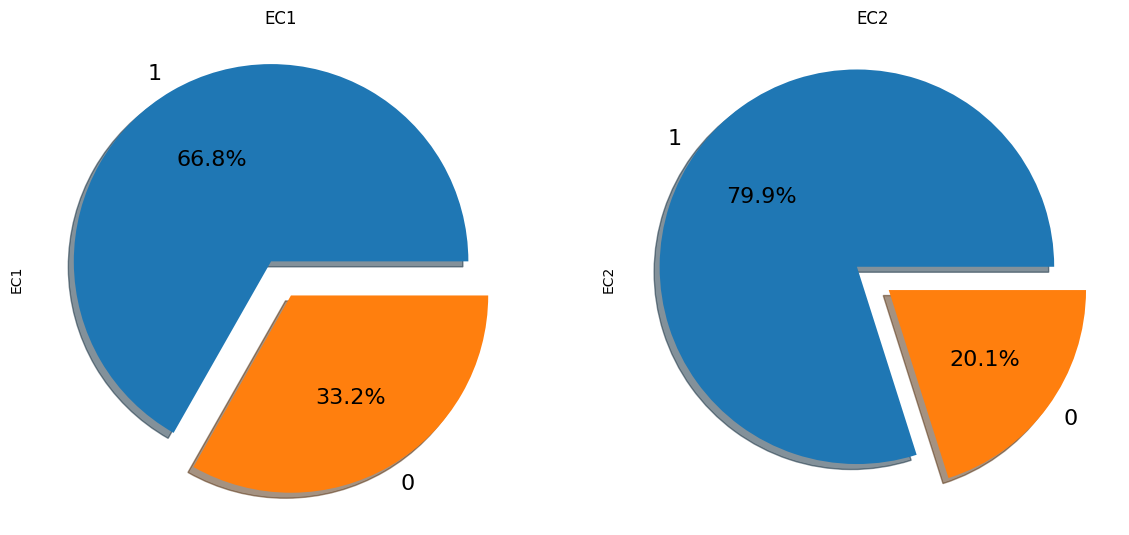

In [10]:
import matplotlib.pyplot as plt

# Define a 1x2 subplot layout
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot for EC1
df['EC1'].value_counts().plot.pie(ax=ax[0], explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize': 16})
ax[0].set_title("EC1")

# Plot for EC2
df['EC2'].value_counts().plot.pie(ax=ax[1], explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize': 16})
ax[1].set_title("EC2")

# Show the plot
plt.show()

In [11]:
##From https://www.kaggle.com/code/arootda/pycaret-visualization-optimization-0-81/notebook
from IPython.core.display import HTML

def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

multi_table([pd.DataFrame(df[i].value_counts()) for i in df.columns if i != 'Your ad could be here'])

In [12]:
class NullDetector:
    """
    A class for detecting and visualizing null values in a DataFrame.
    """
    
    def __init__(self):
        pass

    def detect_nulls(self, df):
        """
        Detects and visualizes null values in a DataFrame.
        
        Args:
            df (pandas.DataFrame): The DataFrame to analyze.
        """
        # Count of all null values in dataframe columns
        null_count = df.isnull().sum()
        
        # Calculate the percentage of null values in each column
        null_percentage = (df.isnull().sum() / df.shape[0]) * 100
    
        # Create a dataframe for output
        null_df = pd.DataFrame({'Null Count': null_count, 'Null Percentage': null_percentage})
        
        print("Number and percentage of null values in df columns:")
        print(null_df)
    
        # Nullity matrix to find null value in dataframe
        plt.figure(figsize=(15, 10))
        sns.heatmap(df.isnull(), cmap="YlGnBu", cbar_kws={'label': 'Missing Data'})
        plt.title("Nullity Matrix")
        plt.xlabel("Columns")
        plt.ylabel("Rows")
        plt.show()

In [13]:
null_detector = NullDetector()

Number and percentage of null values in df columns:
                   Null Count  Null Percentage
id                          0              0.0
BertzCT                     0              0.0
Chi1                        0              0.0
Chi1n                       0              0.0
Chi1v                       0              0.0
Chi2n                       0              0.0
Chi2v                       0              0.0
Chi3v                       0              0.0
Chi4n                       0              0.0
EState_VSA1                 0              0.0
EState_VSA2                 0              0.0
ExactMolWt                  0              0.0
FpDensityMorgan1            0              0.0
FpDensityMorgan2            0              0.0
FpDensityMorgan3            0              0.0
HallKierAlpha               0              0.0
HeavyAtomMolWt              0              0.0
Kappa3                      0              0.0
MaxAbsEStateIndex           0              0.0
MinEStat

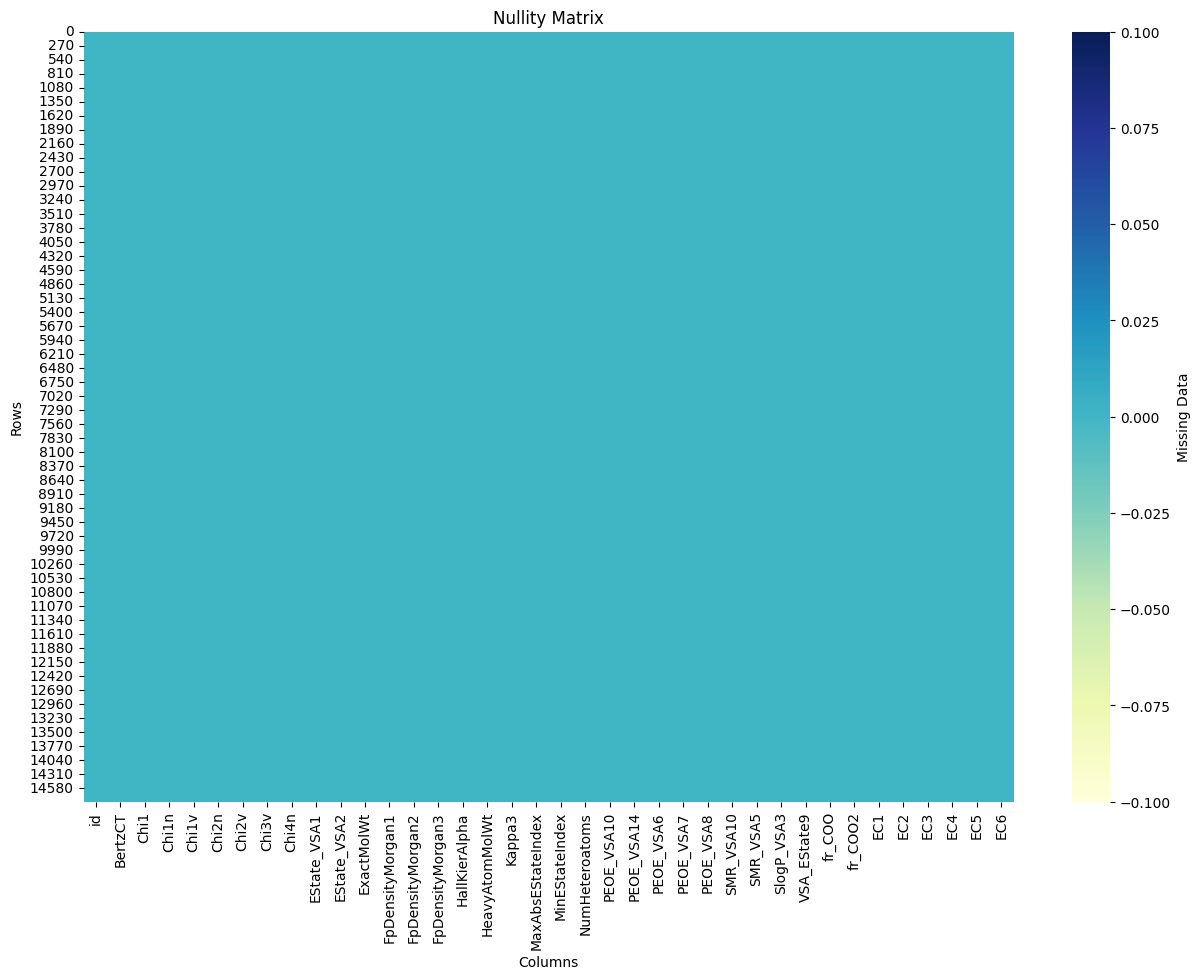

In [14]:
null_detector.detect_nulls(df)

Number and percentage of null values in df columns:
                   Null Count  Null Percentage
id                          0              0.0
BertzCT                     0              0.0
Chi1                        0              0.0
Chi1n                       0              0.0
Chi1v                       0              0.0
Chi2n                       0              0.0
Chi2v                       0              0.0
Chi3v                       0              0.0
Chi4n                       0              0.0
EState_VSA1                 0              0.0
EState_VSA2                 0              0.0
ExactMolWt                  0              0.0
FpDensityMorgan1            0              0.0
FpDensityMorgan2            0              0.0
FpDensityMorgan3            0              0.0
HallKierAlpha               0              0.0
HeavyAtomMolWt              0              0.0
Kappa3                      0              0.0
MaxAbsEStateIndex           0              0.0
MinEStat

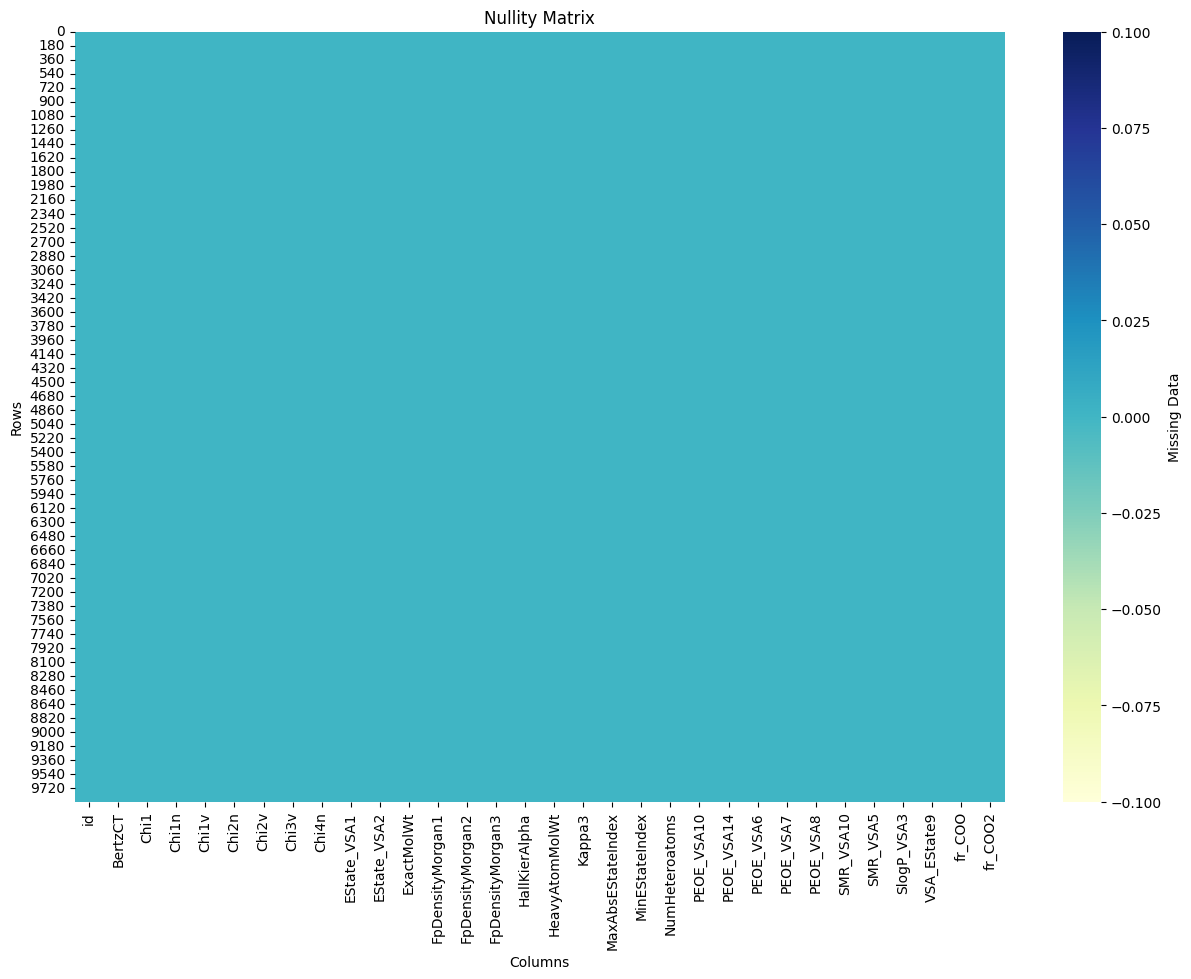

In [15]:
null_detector.detect_nulls(test)

In [16]:
def plot_histograms(df):
    # Select numerical columns which are not binary
    numerical_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    non_binary_cols = [col for col in numerical_cols if df[col].nunique() > 2]

    # Create a grid of histograms
    n = len(non_binary_cols)
    ncols = 3
    nrows = n // ncols + (n % ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*5))
    axes = axes.flatten()

    # Plot data
    for ax, col in zip(axes, non_binary_cols):
        sns.histplot(df[col], ax=ax, kde=True)
        ax.set_title(f'Histogram of {col}')
        
    # Remove empty subplots
    for idx in range(n, nrows*ncols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# plot_histograms(df)

In [17]:
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

In [18]:
fig, ax = plt.subplots(8, 4, figsize = (20, 30), dpi = 300)
ax = ax.flatten()
numerical_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
non_binary_cols = [col for col in numerical_cols if df[col].nunique() > 2]
for i, column in enumerate(non_binary_cols):
    sns.kdeplot(df[column], ax=ax[i], color=pal[0])    
    sns.kdeplot(test[column], ax=ax[i], color=pal[1])
#     sns.kdeplot(orig_train[column], ax=ax[i], color=pal[1])
    
    ax[i].set_title(f'{column} Distribution', size = 7)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Numerical Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
#fig.legend(['Train', 'Test'])
plt.tight_layout()

<AxesSubplot: >

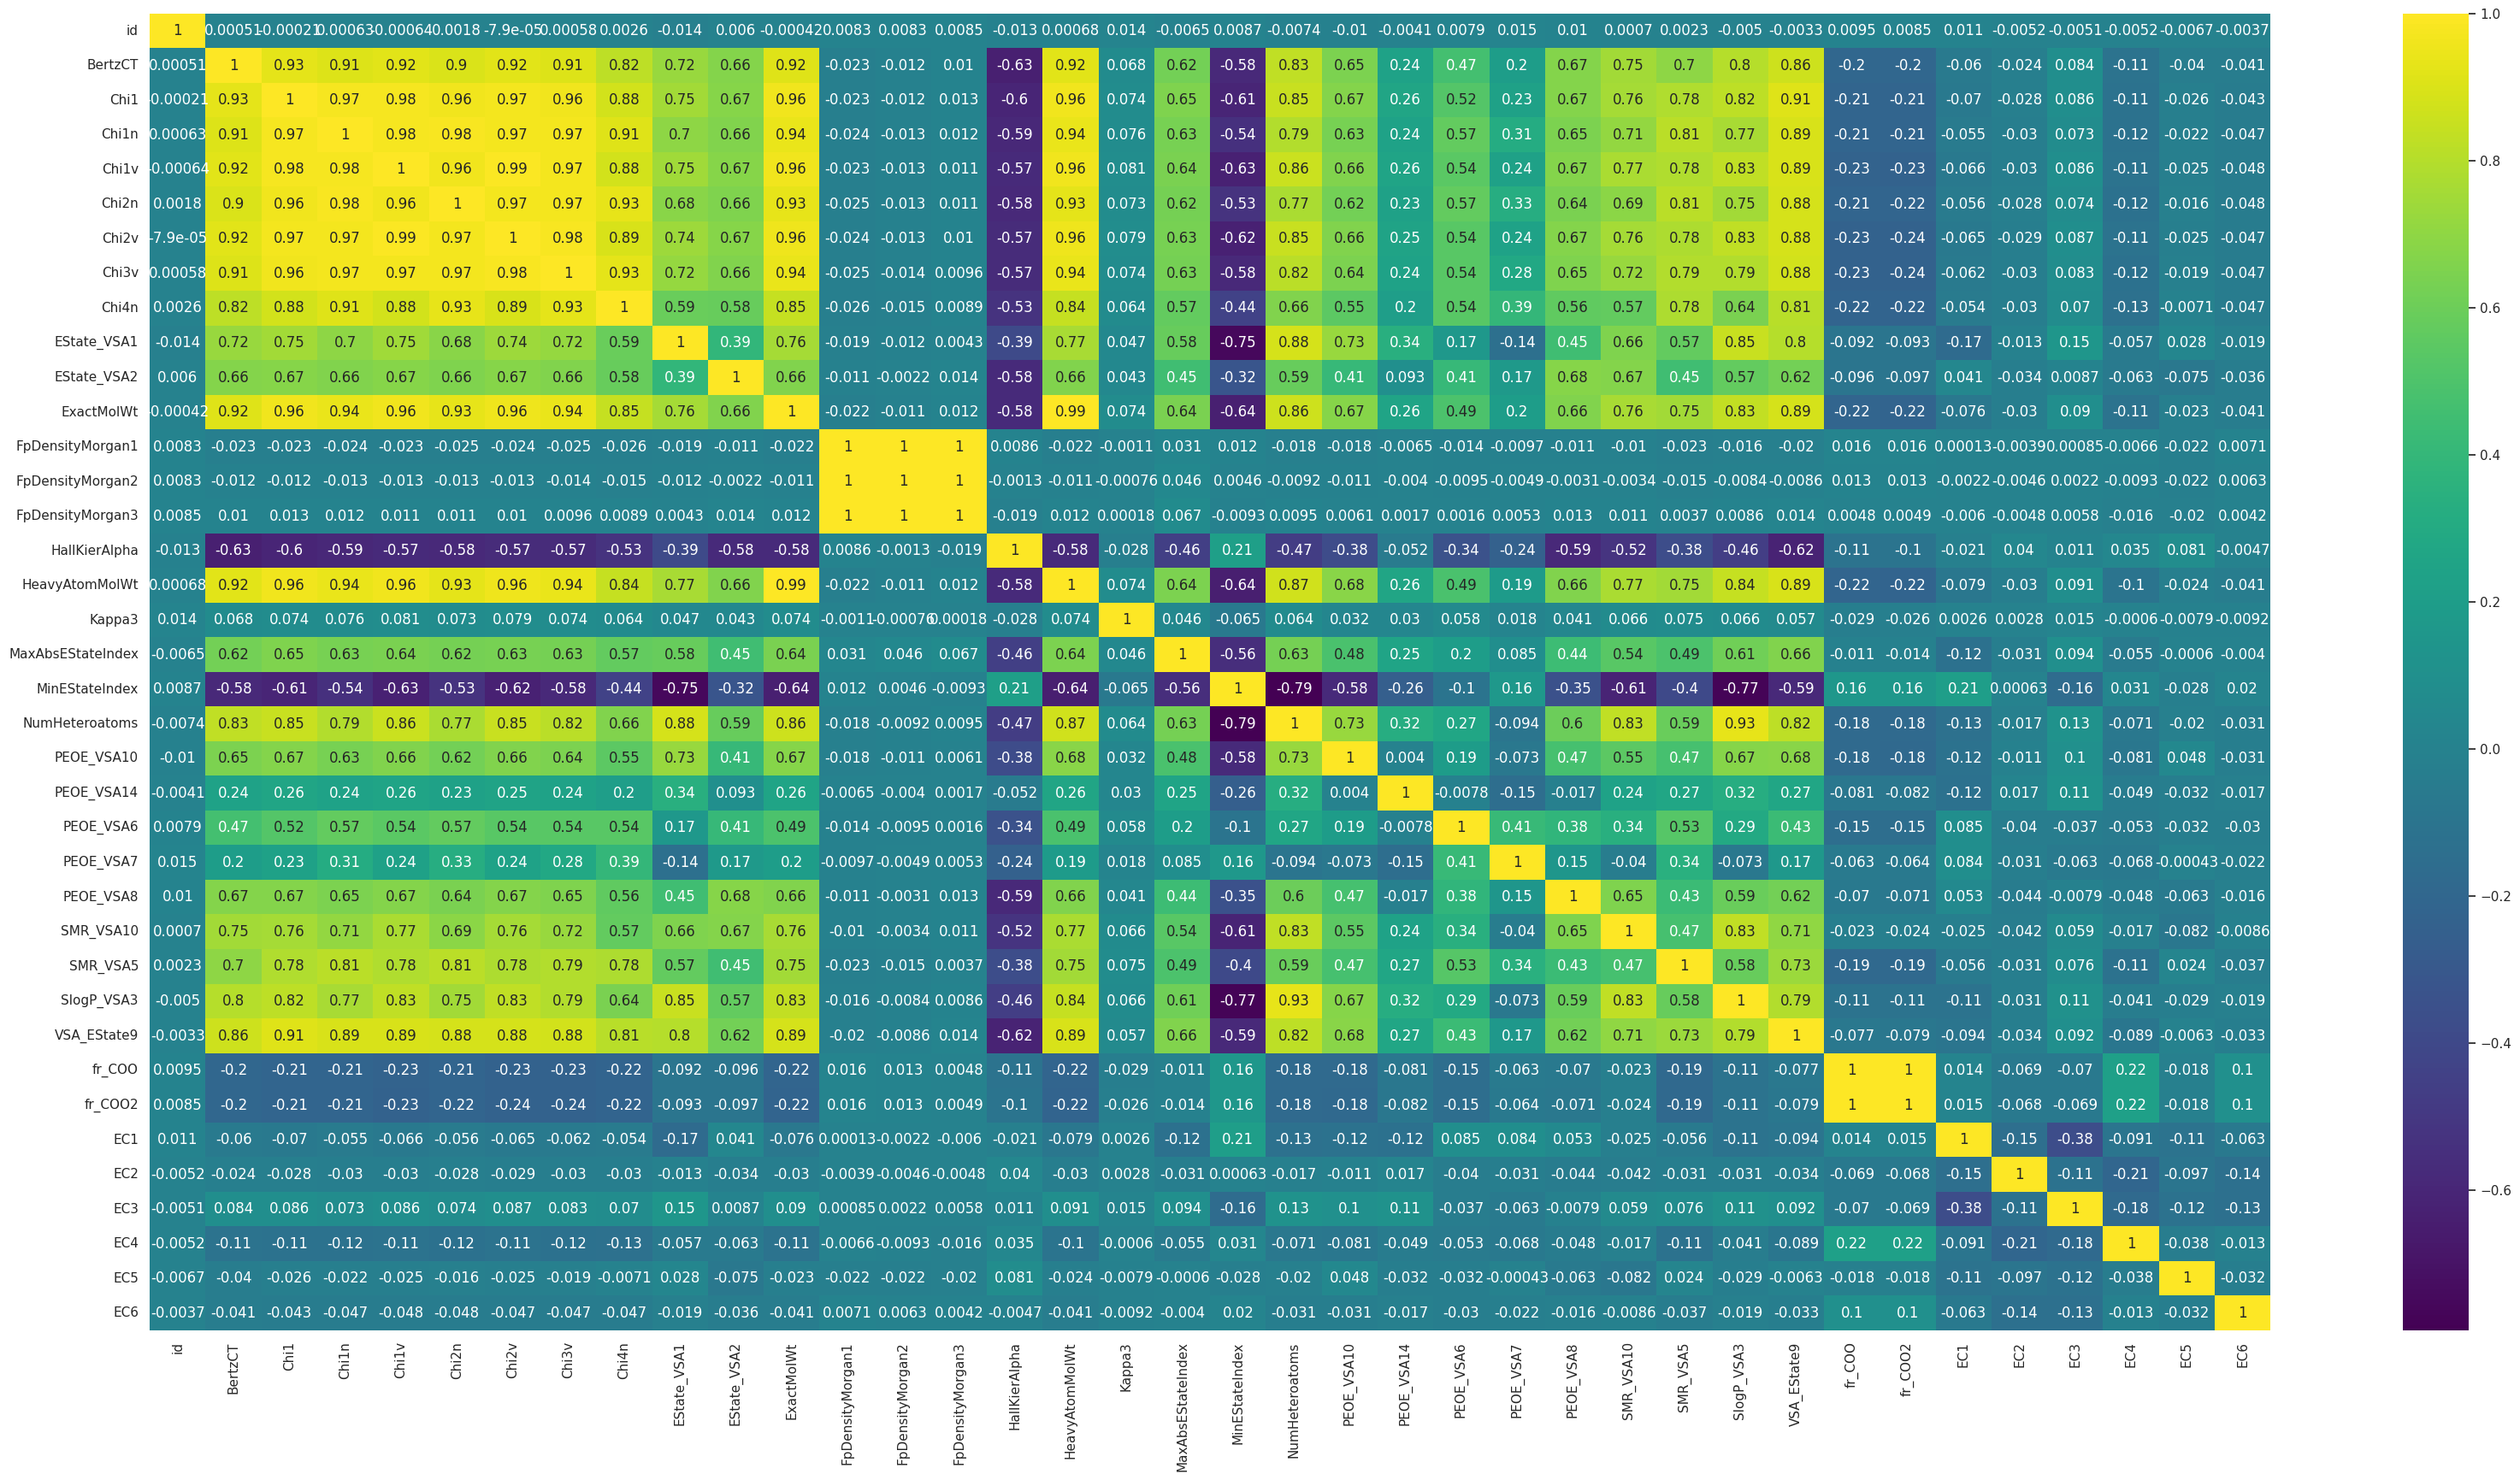

In [19]:
# Pearson correlation map
cols = df.corr().index
cm = df[cols].corr()
plt.figure(figsize=(40, 20))
sns.heatmap(cm, annot=True, cmap='viridis')

In [20]:
def plot_boxplots(df, target):
    # Select numerical columns which are not binary
    numerical_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    non_binary_cols = [col for col in numerical_cols if df[col].nunique() > 2]

    # Create a grid of boxplots
    n = len(non_binary_cols)
    ncols = 3
    nrows = n // ncols + (n % ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*5))
    axes = axes.flatten()

    # Plot data
    for ax, col in zip(axes, non_binary_cols):
        sns.boxplot(x=target, y=col, data=df, ax=ax)
        ax.set_title(f'Boxplot of {col} by {target}')
        
    # Remove empty subplots
    for idx in range(n, nrows*ncols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# plot_boxplots(df, 'EC1')

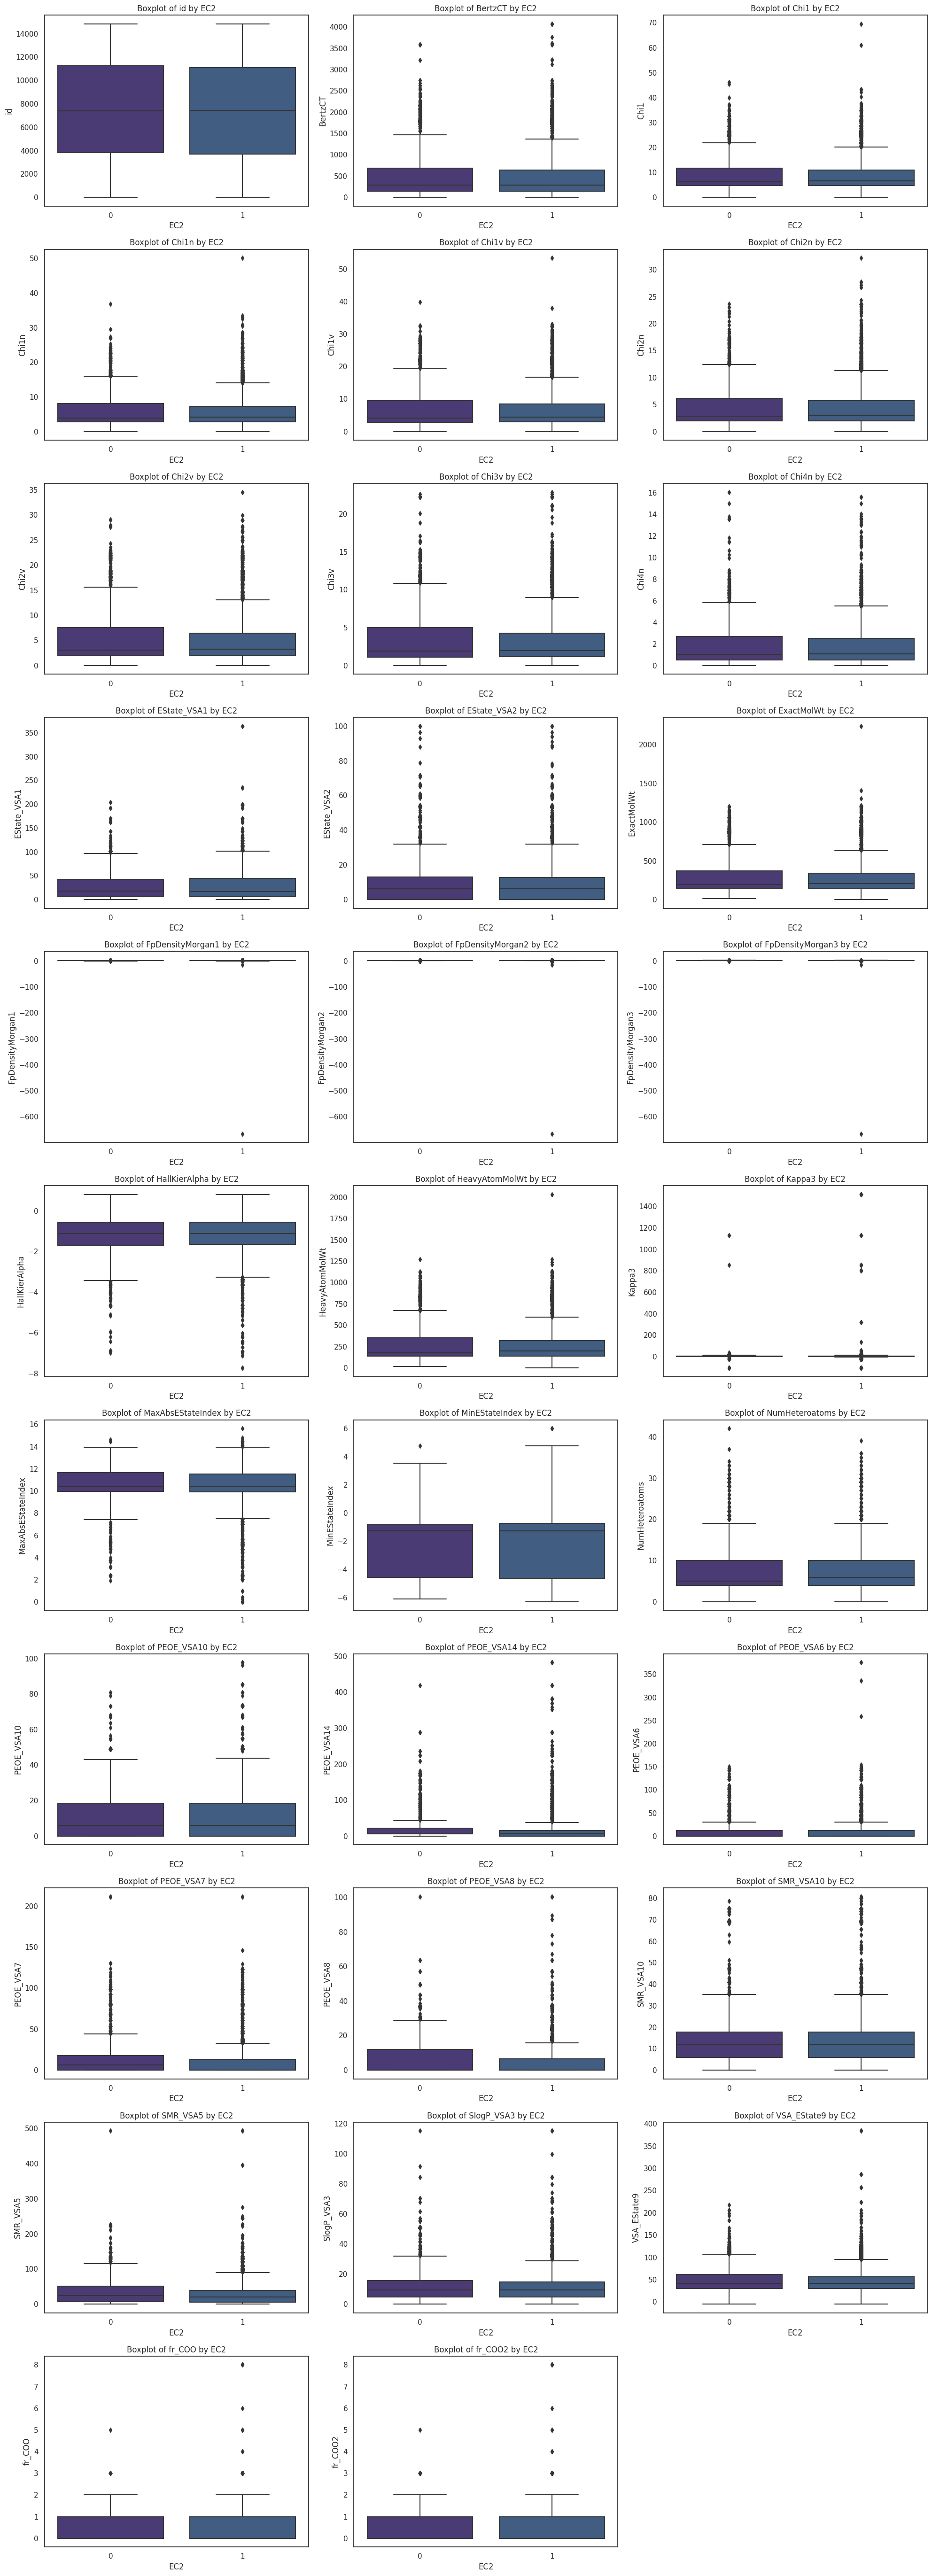

In [21]:
def plot_boxplots(df, target):
    # Select numerical columns which are not binary
    numerical_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    non_binary_cols = [col for col in numerical_cols if df[col].nunique() > 2]

    # Create a grid of boxplots
    n = len(non_binary_cols)
    ncols = 3
    nrows = n // ncols + (n % ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*5))
    axes = axes.flatten()

    # Plot data
    for ax, col in zip(axes, non_binary_cols):
        sns.boxplot(x=target, y=col, data=df, ax=ax)
        ax.set_title(f'Boxplot of {col} by {target}')
        
    # Remove empty subplots
    for idx in range(n, nrows*ncols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

plot_boxplots(df, 'EC2')

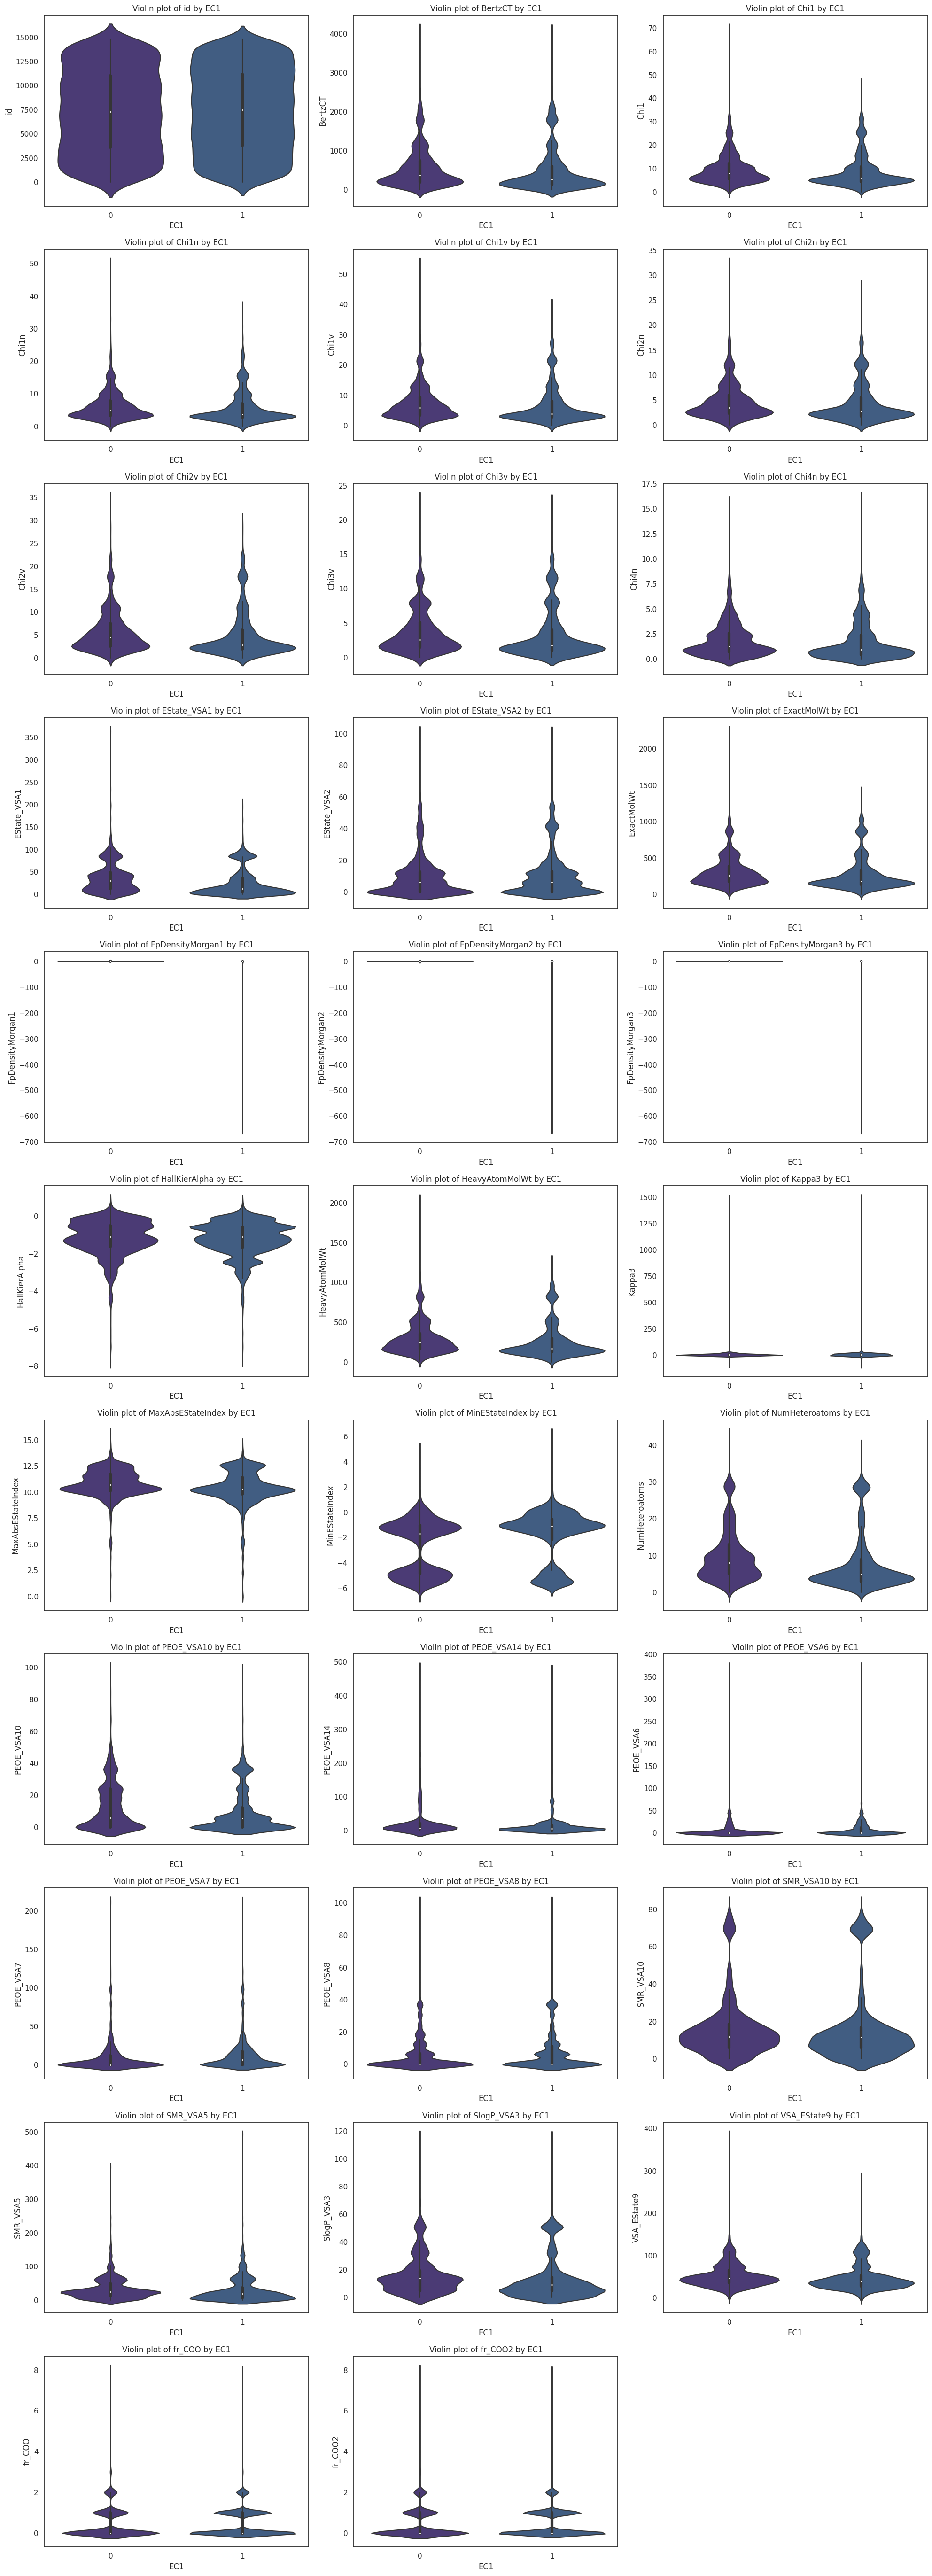

In [22]:
def plot_violinplots(df, target):
    # Select numerical columns which are not binary
    numerical_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    non_binary_cols = [col for col in numerical_cols if df[col].nunique() > 2]

    # Create a grid of violin plots
    n = len(non_binary_cols)
    ncols = 3
    nrows = n // ncols + (n % ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*5))
    axes = axes.flatten()

    # Plot data
    for ax, col in zip(axes, non_binary_cols):
        sns.violinplot(x=target, y=col, data=df, ax=ax)
        ax.set_title(f'Violin plot of {col} by {target}')
        
    # Remove empty subplots
    for idx in range(n, nrows*ncols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

plot_violinplots(df, 'EC1')

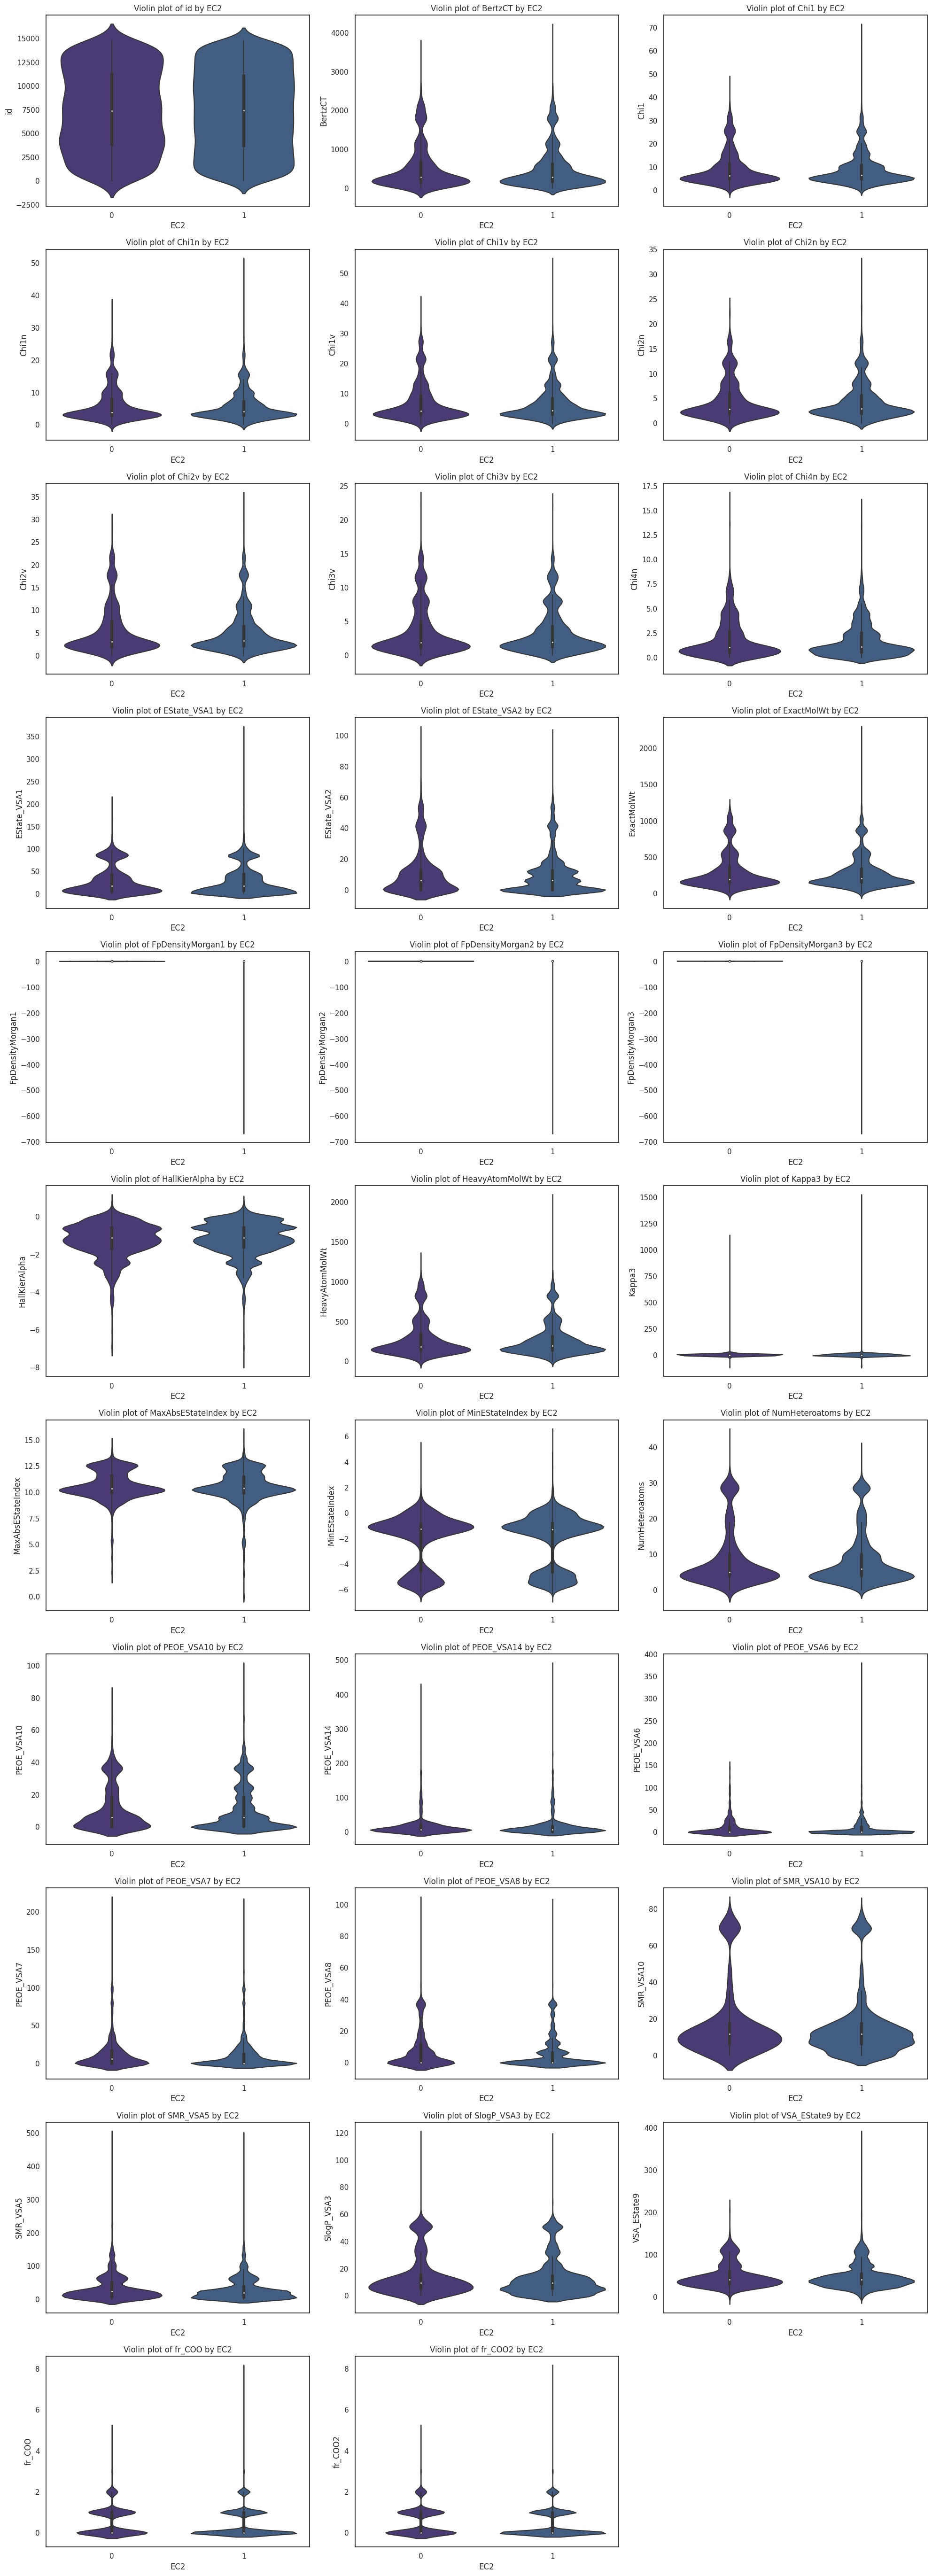

In [23]:
def plot_violinplots(df, target):
    # Select numerical columns which are not binary
    numerical_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    non_binary_cols = [col for col in numerical_cols if df[col].nunique() > 2]

    # Create a grid of violin plots
    n = len(non_binary_cols)
    ncols = 3
    nrows = n // ncols + (n % ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*5))
    axes = axes.flatten()

    # Plot data
    for ax, col in zip(axes, non_binary_cols):
        sns.violinplot(x=target, y=col, data=df, ax=ax)
        ax.set_title(f'Violin plot of {col} by {target}')
        
    # Remove empty subplots
    for idx in range(n, nrows*ncols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

plot_violinplots(df, 'EC2')

# Feature enginering

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn_pandas import DataFrameMapper

class DataFramePreprocessing(TransformerMixin, BaseEstimator):
    '''DataFramePreprocessing class fits and transforms all features and returns a Pandas DataFrame'''

    def __init__(self):
        '''
        Constructor for DataFramePreprocessing class.

        Parameters:
        - X (pandas.DataFrame): Input DataFrame.
        '''
        
    def get_features(self, X):
        '''
        Extracts the numeric, categorical, and boolean features from the input DataFrame.

        Parameters:
        - X (pandas.DataFrame): Input DataFrame.

        Returns:
        - None
        '''
        self.numerical_features = X.select_dtypes(include=['int16', 'float16', 'int32', 'float32', 'int64', 'float64']).columns
        self.categorical_features = X.select_dtypes(include=['object']).columns
        self.boolean_features = X.select_dtypes(include=['bool']).columns
        
    def categorical_transformer(self):
        '''
        Creates a list of tuples specifying the transformations for categorical features.

        Returns:
        - list: List of tuples, where each tuple contains a feature name and a transformation pipeline.
        '''
        return [([feature], [SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-999)]) for feature in self.categorical_features]

    def numerical_transformer(self):
        '''
        Creates a list of tuples specifying the transformations for numerical features.

        Returns:
        - list: List of tuples, where each tuple contains a feature name and a transformation pipeline.
        '''
        return [([feature], [SimpleImputer(strategy='most_frequent'), StandardScaler()]) for feature in self.numerical_features]

    def boolean_transformer(self):
        '''
        Creates a list of tuples specifying the transformations for boolean features.

        Returns:
        - list: List of tuples, where each tuple contains a feature name and a transformation pipeline.
        '''
        return [([feature], [SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-999)]) for feature in self.boolean_features]

    def mapper(self):
        '''
        Creates a DataFrameMapper object that combines all the feature transformations.

        Returns:
        - DataFrameMapper: DataFrameMapper object that applies the specified transformations to the input data.
        '''
        self.get_features(X)
        return DataFrameMapper(self.numerical_transformer() + self.categorical_transformer() + self.boolean_transformer(), df_out=True)

    def fit(self, X, y=None):
        '''
        Fits the DataFramePreprocessing transformer on the input data.

        Parameters:
        - X (array-like or DataFrame): Input data to fit the transformer on.
        - y (array-like or None): Target values (ignored).

        Returns:
        - self: Returns the instance itself.
        '''
        X = X.copy()
        X = check_array(X, accept_sparse=False)

        self.n_features_in_ = X.shape[1]
        self.n_features_ = X.shape[1]
        self.is_fitted_ = True

        return self

    def transform(self, X):
        '''
        Transforms the input data using the fitted DataFramePreprocessing transformer.
    
        Parameters:
        - X (array-like or DataFrame): Input data to transform.
    
        Returns:
        - array-like or DataFrame: Transformed data.
        '''
        X = X.copy()
        check_is_fitted(self, ['is_fitted_'])
        X = check_array(X, accept_sparse=True)
    
        if X.shape[1] != self.n_features_:
            raise ValueError('Shape of input is different from what was seen in `fit`')
        return X

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from collections import Counter

class OutliersDetector:
    """Class to detect and handle outliers in a dataframe."""
    
    def __init__(self, df, method="iqr"):
        """
        Initialize OutliersDetector with dataframe and method.
        
        :param df: input DataFrame
        :param method: method for outlier detection; "iqr" for Interquartile Range, "sd" for Standard Deviation, "zscore" for Z-Score
        """
        self.df = df
        self.method = method
        # Select numerical columns in the dataframe
        self.numerical_features = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

    def detect_outliers_iqr(self):
        """Detect outliers using the Interquartile Range (IQR) method."""
        outlier_indices = []
        for c in self.numerical_features:
            # Calculate Q1, Q3, and IQR for each numerical column
            Q1 = np.percentile(self.df[c], 25)
            Q3 = np.percentile(self.df[c], 75)
            IQR = Q3 - Q1
            # Identify outlier step
            outlier_step = IQR * 1.5
            # Get indices of outliers
            outlier_list_col = self.df[(self.df[c] < Q1 - outlier_step) | (self.df[c] > Q3 + outlier_step)].index
            outlier_indices.extend(outlier_list_col)
        # Count indices appearing more than twice
        outlier_indices = Counter(outlier_indices)
        self.multiple_outliers = [i for i, v in outlier_indices.items() if v > 2]
        return self.multiple_outliers

    def detect_outliers_sd(self):
        """Detect outliers using the Standard Deviation (SD) method."""
        outlier_indices = []
        for c in self.numerical_features:
            # Calculate mean and standard deviation for each numerical column
            mean, std_dev = self.df[c].mean(), self.df[c].std()
            # Identify cutoff for outliers (mean ± 3*standard_deviation)
            cutoff = std_dev * 3
            lower, upper = mean - cutoff, mean + cutoff
            # Get indices of outliers
            outlier_list_col = self.df[(self.df[c] < lower) | (self.df[c] > upper)].index
            outlier_indices.extend(outlier_list_col)
        # Count indices appearing more than twice
        outlier_indices = Counter(outlier_indices)
        self.multiple_outliers = [i for i, v in outlier_indices.items() if v > 2]
        return self.multiple_outliers

    def detect_outliers_zscore(self):
        """Detect outliers using the Z-Score method."""
        # Calculate z-scores for each numerical column
        z_scores = self.df[self.numerical_features].apply(zscore)
        # Get indices of outliers (z-score > 3 or z-score < -3)
        self.multiple_outliers = z_scores[np.abs(z_scores) > 3].dropna(how='all').index.to_list()
        return self.multiple_outliers

    def detect_outliers(self):
        """Detect outliers using the chosen method."""
        if self.method == "iqr":
            return self.detect_outliers_iqr()
        elif self.method == "sd":
            return self.detect_outliers_sd()
        elif self.method == "zscore":
            return self.detect_outliers_zscore()
        else:
            raise ValueError("Invalid method. Expected one of: 'iqr', 'sd', 'zscore'")

    def drop_outliers(self):
        """Drop the detected outliers from the dataframe."""
        self.df = self.df.drop(self.detect_outliers(), axis = 0)
        return self.df

    def show_outliers(self):
        """Show the detected outliers."""
        if self.multiple_outliers:
            print(f"Detected {len(self.multiple_outliers)} outliers.")
        else:
            print("No outliers detected.")
        return self.multiple_outliers

    def visualize_outliers(self):
        """Visualize the outliers for each numerical feature using boxplots."""
        for feature in self.numerical_features:
            plt.figure(figsize=(10,4))
            sns.boxplot(x=self.df[feature])
            plt.title(f'Boxplot of {feature}')
            plt.show()

out = OutliersDetector(df, method='iqr')
df1 = out.drop_outliers()

In [26]:
out = OutliersDetector(df, method='sd')
df1 = out.drop_outliers()

out = OutliersDetector(df1, method='zscore')
df1 = out.drop_outliers()

In [27]:
df.shape, df1.shape

((14838, 38), (14355, 38))

In [28]:
def optimize_data_types(df):
    optimized_df = df.copy()

    for column in optimized_df.columns:
        current_dtype = optimized_df[column].dtype

        if current_dtype == object:
            # Convert object columns to categorical if unique values are less than 50% of total values
            unique_count = len(optimized_df[column].unique())
            total_count = len(optimized_df[column])
            if unique_count / total_count < 0.5:
                optimized_df[column] = optimized_df[column].astype("category")
        elif current_dtype == int:
            # Downcast int columns to smaller types if possible
            optimized_df[column] = pd.to_numeric(optimized_df[column], downcast="integer")
        elif current_dtype == float:
            # Downcast float columns to smaller types if possible
            optimized_df[column] = pd.to_numeric(optimized_df[column], downcast="float")
        elif current_dtype == bool:
            # Convert bool columns to integers
            optimized_df[column] = optimized_df[column].astype(int)
        elif "datetime" in str(current_dtype):
            # Convert datetime columns to datetime type
            optimized_df[column] = pd.to_datetime(optimized_df[column])

    return optimized_df

In [29]:
df1 = optimize_data_types(df1)
test= optimize_data_types(test)

In [30]:
from xgboost import XGBClassifier

# Data split

In [31]:
df1

id     BertzCT       Chi1     Chi1n      Chi1v     Chi2n      Chi2v  \
0          0  323.390778   9.879918  5.875576   5.875576  4.304757   4.304757   
1          1  273.723785   7.259037  4.441467   5.834958  3.285046   4.485235   
2          2  521.643799  10.911303  8.527860  11.050864  6.665291   9.519706   
3          3  567.431152  12.453343  7.089119  12.833710  6.478023  10.978151   
4          4  112.770737   4.414720  2.866236   2.866236  1.875634   1.875634   
...      ...         ...        ...       ...        ...       ...        ...   
14833  14833  632.207031  10.911303  6.579933   9.179963  4.653583   6.030052   
14834  14834   62.568424   2.642735  1.446898   1.446898  0.879497   0.879497   
14835  14835  981.327454  10.363081  6.146219   6.146219  4.700576   4.700576   
14836  14836  299.171234   9.949161  6.589761   7.848913  5.276568   5.476436   
14837  14837  785.394043  15.671142  9.896164  10.234263  7.860296   8.522605   

          Chi3v     Chi4n  EState_VSA1  ...  SlogP_VSA3  VSA_EState9  fr_COO  \
0      2.754513  1.749203     0.000000  ...    4.794537    35.527355       0   
1      2.201375  1.289775    45.135471  ...   13.825659    44.707310       0   
2      5.824822  1.770579    15.645394  ...   17.964476    45.660118       0   
3      7.914542  3.067181    95.639557  ...   31.961948    87.509995       0   
4      1.036450  0.727664    17.980452  ...    9.589074    33.333332       2   
...         ...       ...          ...  ...         ...          ...     ...   
14833  3.670528  1.770579    32.971527  ...   18.947453    61.376610       0   
14834  0.174620  0.000000     0.000000  ...    0.000000    10.000000       0   
14835  3.064846  2.133897    17.248535  ...    0.000000    66.666664       0   
14836  3.978973  2.299833    45.623795  ...    9.088796    45.583332       0   
14837  5.645502  3.312893    82.448242  ...   22.701338    71.127045       0   

       fr_COO2  EC1  EC2  EC3  EC4  EC5  EC6  
0            0    1    1    0    0    0    0  
1            0    0    1    1    0    0    0  
2            0    1    1    0    0    1    0  
3            0    1    1    0    0    0    0  
4            2    1    0    1    1    1    0  
...        ...  ...  ...  ...  ...  ...  ...  
14833        0    1    1    0    0    0    0  
14834        0    0    1    0    1    0    0  
14835        0    1    1    0    0    0    0  
14836        0    0    1    1    0    0    0  
14837        0    0    1    0    1    0    0  

[14355 rows x 38 columns]

In [32]:
df1 = df1.drop(['id','HeavyAtomMolWt','fr_COO2'], axis = 1)

In [33]:
test = test.drop(['id','HeavyAtomMolWt','fr_COO2'], axis = 1)

In [34]:
test

BertzCT       Chi1      Chi1n      Chi1v      Chi2n      Chi2v  \
0      344.632385   7.283604   4.473966   5.834958   3.412257   4.651530   
1     1432.410156  10.663869   7.079026   8.065215   5.297097   5.297097   
2       83.352608   3.931852   1.774215   1.774215   1.073446   1.073446   
3      150.255707   5.912790   3.548812   3.548812   2.595128   2.595128   
4     1817.276367  24.910940  15.540529  20.047314  12.535886  17.730988   
...           ...        ...        ...        ...        ...        ...   
9888   246.422867   4.036581   2.816709   2.816709   1.875634   1.875634   
9889   591.069702   8.770857   5.682461   5.682461   4.050440   4.050440   
9890   378.113434   6.310349   3.402334   4.317724   2.817428   4.071979   
9891   737.653503   9.949161   7.337949   7.337949   4.428511   5.948361   
9892   785.394043  12.170505   7.565385   9.651755   5.842572   8.229500   

          Chi3v     Chi4n  EState_VSA1  EState_VSA2  ...  PEOE_VSA10  \
0      2.096558  1.116433    49.458580     0.000000  ...   18.311899   
1      3.924155  2.569694     0.000000    29.783175  ...    0.000000   
2      0.467830  0.170838     5.969306     6.420822  ...    0.000000   
3      1.642813  0.694113     0.000000     0.000000  ...    0.000000   
4     11.979618  4.431173    84.554970    47.360207  ...   36.259888   
...         ...       ...          ...          ...  ...         ...   
9888   1.235986  0.362743    24.146544     6.420822  ...   12.207932   
9889   2.167855  1.770579     0.000000    28.228516  ...    5.749512   
9890   1.970236  1.165747    36.705948     0.000000  ...   24.918781   
9891   3.972459  2.160881    36.992054     0.000000  ...   36.259888   
9892   5.664696  2.587586    49.458580    11.163877  ...   18.311899   

      PEOE_VSA14  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  SMR_VSA10   SMR_VSA5  \
0      13.512441   0.000000   0.000000   0.000000  26.809273  24.539801   
1       0.000000  34.947372  98.323990   9.606882   0.000000  53.378235   
2       5.969306   0.000000   0.000000   6.420822  11.752550  13.344559   
3      59.935299   0.000000   0.000000   0.000000  17.744066  32.290169   
4      23.468092  25.609360   0.000000  37.098999  69.141350  38.704128   
...          ...        ...        ...        ...        ...        ...   
9888   11.938611   0.000000   0.000000   0.000000  11.938611  12.207932   
9889    0.000000  18.199100  37.107113  17.696186  10.969244   0.000000   
9890    7.822697   0.000000   0.000000   0.000000   7.822697  24.099010   
9891    0.000000   0.000000   0.000000   6.196844   0.000000  12.462663   
9892    7.822697   0.000000   0.000000   0.000000  18.872231  24.539801   

      SlogP_VSA3  VSA_EState9  fr_COO  
0       4.794537    47.304081       1  
1       0.000000    43.166668       0  
2       9.589074    24.666666       1  
3       4.794537    26.778866       0  
4      50.697491   102.583336       0  
...          ...          ...     ...  
9888    9.589074    30.000000       2  
9889    0.000000    53.166668       0  
9890    4.736863    50.652870       0  
9891    9.589074    50.250000       0  
9892   13.825659    69.130959       0  

[9893 rows x 29 columns]

In [35]:
X = df1.iloc[:, :-6]
y = df1.iloc[:, -6:-4]

In [36]:
k = MultilabelStratifiedKFold(n_splits = CFG.splits, random_state = CFG.SEED, shuffle = True)

In [37]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [38]:
preprocessing = DataFramePreprocessing()

In [39]:
from sklearn.calibration import CalibratedClassifierCV

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

# train classifier for 'EC1'
clf = XGBClassifier(random_state=CFG.SEED)
clf.fit(X_train, y_train)

# calibrate classifier on validation data
calibrator = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
steps = [('scaler', preprocessing)]  # Create a list of tuples with the steps
# steps.append(("power_transform", PowerTransformer())) 
steps.append(("model", calibrator)) 
pipeline = Pipeline(steps=steps)
model_calibrate = calibrator.fit(X_val, y_val)
model_calibrate = model_calibrate.fit(X_val, y_val)
pred = model_calibrate.predict_proba(X_val)

print(f"model_calibrate roc_auc :{roc_auc_score(y_val,pred)}")

model_calibrate roc_auc :0.5046367221536195


In [42]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier

In [45]:
class Classifier:
    def __init__(self,  device="cpu", random_state=42):        

        self.device = device
        self.random_state = random_state
        self.models = self.get_models()
        self.models_name = list(self.get_models().keys())
        self.len_models = len(self.models)
        
    def get_models(self):        
        best_params_xgb = {            
            'max_depth': 9,
            'min_child_weight': 3,
            'gamma': 0.6732144777549619,
            'max_bin': 768,
            'reg_alpha': 0.6644517984949172,
            'n_estimators': 340,
            'colsample_bytree': 0.5344011345549046,
            'learning_rate': 5.04493455393149e-05,
            'subsample': 0.5019144936083529
        }
         
        best_params_xgb2={
            'max_depth': 7,
            'min_child_weight': 8,
            'gamma': 0.9643242978627755,
            'max_bin': 512,
            'reg_alpha': 0.48092384189013426,
            'n_estimators': 220,
            'colsample_bytree': 0.4176860214215391,
            'learning_rate': 0.03531988274488159,
            'subsample': 0.4106186205099238
        }
        
        
        best_params_lgbm_2={
            'max_depth': 5,
            'min_child_weight': 11,
            'max_bin': 1792,
            'reg_alpha': 0.62602091852341,
            'n_estimators': 310,
            'colsample_bytree': 0.5585884321502342,
            'learning_rate': 0.029869581300940928,
            'subsample': 0.776509980259304
        }
        
        best_params_lgbm={
            'boosting_type': 'dart',
            'max_depth': 7,
            'min_child_weight': 8,
            'max_bin': 1792,
            'reg_alpha': 0.09349129960255663,
            'n_estimators': 280,
            'colsample_bytree': 0.5154631182371853,
            'learning_rate': 0.010460135005314935,
            'subsample': 0.8804781735034546,
        }
        
        models = {            
#             "xgbo1": XGBClassifier(
#                 n_jobs=-1,
#                 tree_method = 'gpu_hist',                
#                 objective='binary:logistic',
#                 random_state=self.random_state,
#                 **best_params_xgb2
#             ),
            "xgb2": BaggingClassifier(XGBClassifier(
                n_jobs=-1,
                tree_method = 'gpu_hist',                
                objective='binary:logistic',
                random_state=self.random_state,
                **best_params_xgb
            )),

#             "lgbo1": LGBMClassifier(
#                 random_state=self.random_state,
#                 **best_params_lgbm_2
#             ),
            "lgb2": BaggingClassifier(LGBMClassifier(
                random_state=self.random_state,
                **best_params_lgbm
            )),
            

        }
        return models


In [46]:
# Initialize an array for storing test predictions
classifier = Classifier(device="cpu", random_state=CFG.SEED)
models = classifier.models

In [47]:
from sklearn.multioutput import MultiOutputClassifier

In [48]:
def generate_features(train, test, cat_cols, num_cols):
    
    df = pd.concat([train, test], axis = 0, copy = False)
    
    for c in cat_cols + num_cols:
        
        df[f'count_{c}'] = df.groupby(c)[c].transform('count')
        df[f'mean_{c}'] = df.groupby(c)[c].transform('mean')
        df[f'var_{c}'] = df.groupby(c)[c].transform('median')
#         df[f'std{c}'] = df.groupby(c)[c].transform('var')
        df[f'sum_{c}'] = df.groupby(c)[c].transform('sum')
#         df[f'log{c}'] = df.groupby(c)[c].transform('log')
    for c in cat_cols:
        for n in num_cols:
                df[f'mean_{n}_per_{c}'] = df.groupby(c)[n].transform('mean')
#                 df[f'std{n}_per_{c}'] = df.groupby(c)[n].transform('std')
#                 df[f'sum{n}_per_{c}'] = df.groupby(c)[n].transform('sum')
#                 df[f'len{n}_per_{c}'] = df.groupby(c)[n].transform('len')
#                 df[f'log{n}_per_{c}'] = df.groupby(c)[n].transform('log')
                
    return df.iloc[:len(train),:], df.iloc[len(train):, :] 

In [49]:
target_cols = ['EC1', 'EC2']


cat_cols = ['EState_VSA2','HallKierAlpha','NumHeteroatoms','PEOE_VSA10','PEOE_VSA14','PEOE_VSA6',
            'PEOE_VSA7','PEOE_VSA8', 'SMR_VSA10','SMR_VSA5','SlogP_VSA3','fr_COO','fr_COO2']


In [50]:
num_cols = [i for i in X.columns]

In [51]:
X, test = generate_features(X, test,cat_cols=[], num_cols=num_cols)

In [52]:
X

BertzCT       Chi1     Chi1n      Chi1v     Chi2n      Chi2v  \
0      323.390778   9.879918  5.875576   5.875576  4.304757   4.304757   
1      273.723785   7.259037  4.441467   5.834958  3.285046   4.485235   
2      521.643799  10.911303  8.527860  11.050864  6.665291   9.519706   
3      567.431152  12.453343  7.089119  12.833710  6.478023  10.978151   
4      112.770737   4.414720  2.866236   2.866236  1.875634   1.875634   
...           ...        ...       ...        ...       ...        ...   
14833  632.207031  10.911303  6.579933   9.179963  4.653583   6.030052   
14834   62.568424   2.642735  1.446898   1.446898  0.879497   0.879497   
14835  981.327454  10.363081  6.146219   6.146219  4.700576   4.700576   
14836  299.171234   9.949161  6.589761   7.848913  5.276568   5.476436   
14837  785.394043  15.671142  9.896164  10.234263  7.860296   8.522605   

          Chi3v     Chi4n  EState_VSA1  EState_VSA2  ...  var_SlogP_VSA3  \
0      2.754513  1.749203     0.000000    11.938294  ...        4.794537   
1      2.201375  1.289775    45.135471     0.000000  ...       13.825659   
2      5.824822  1.770579    15.645394     6.606882  ...       17.964476   
3      7.914542  3.067181    95.639557     0.000000  ...       31.961948   
4      1.036450  0.727664    17.980452    12.841643  ...        9.589074   
...         ...       ...          ...          ...  ...             ...   
14833  3.670528  1.770579    32.971527     6.606882  ...       18.947453   
14834  0.174620  0.000000     0.000000     0.000000  ...        0.000000   
14835  3.064846  2.133897    17.248535     0.000000  ...        0.000000   
14836  3.978973  2.299833    45.623795     0.000000  ...        9.088796   
14837  5.645502  3.312893    82.448242     5.687387  ...       22.701338   

       sum_SlogP_VSA3  count_VSA_EState9  mean_VSA_EState9  var_VSA_EState9  \
0        21589.800781                 37         35.527355        35.527355   
1        18305.171875                 13         44.707310        44.707310   
2         6161.814941                  6         45.660114        45.660118   
3        18761.664062                 54         87.509995        87.509995   
4        28901.468750                 71         33.333332        33.333332   
...               ...                ...               ...              ...   
14833     1686.323242                 18         61.376606        61.376610   
14834        0.000000                 42         10.000000        10.000000   
14835        0.000000                 14         66.666664        66.666664   
14836     2726.638672                 14         45.583332        45.583332   
14837     7014.713379                 25         71.127045        71.127045   

       sum_VSA_EState9  count_fr_COO  mean_fr_COO  var_fr_COO  sum_fr_COO  
0          1314.512085         15159          0.0         0.0           0  
1           581.195007         15159          0.0         0.0           0  
2           273.960693         15159          0.0         0.0           0  
3          4725.539551         15159          0.0         0.0           0  
4          2366.666504          1827          2.0         2.0        3654  
...                ...           ...          ...         ...         ...  
14833      1104.778931         15159          0.0         0.0           0  
14834       420.000000         15159          0.0         0.0           0  
14835       933.333313         15159          0.0         0.0           0  
14836       638.166626         15159          0.0         0.0           0  
14837      1778.176147         15159          0.0         0.0           0  

[14355 rows x 145 columns]

In [53]:
test

BertzCT       Chi1      Chi1n      Chi1v      Chi2n      Chi2v  \
0      344.632385   7.283604   4.473966   5.834958   3.412257   4.651530   
1     1432.410156  10.663869   7.079026   8.065215   5.297097   5.297097   
2       83.352608   3.931852   1.774215   1.774215   1.073446   1.073446   
3      150.255707   5.912790   3.548812   3.548812   2.595128   2.595128   
4     1817.276367  24.910940  15.540529  20.047314  12.535886  17.730988   
...           ...        ...        ...        ...        ...        ...   
9888   246.422867   4.036581   2.816709   2.816709   1.875634   1.875634   
9889   591.069702   8.770857   5.682461   5.682461   4.050440   4.050440   
9890   378.113434   6.310349   3.402334   4.317724   2.817428   4.071979   
9891   737.653503   9.949161   7.337949   7.337949   4.428511   5.948361   
9892   785.394043  12.170505   7.565385   9.651755   5.842572   8.229500   

          Chi3v     Chi4n  EState_VSA1  EState_VSA2  ...  var_SlogP_VSA3  \
0      2.096558  1.116433    49.458580     0.000000  ...        4.794537   
1      3.924155  2.569694     0.000000    29.783175  ...        0.000000   
2      0.467830  0.170838     5.969306     6.420822  ...        9.589074   
3      1.642813  0.694113     0.000000     0.000000  ...        4.794537   
4     11.979618  4.431173    84.554970    47.360207  ...       50.697491   
...         ...       ...          ...          ...  ...             ...   
9888   1.235986  0.362743    24.146544     6.420822  ...        9.589074   
9889   2.167855  1.770579     0.000000    28.228516  ...        0.000000   
9890   1.970236  1.165747    36.705948     0.000000  ...        4.736863   
9891   3.972459  2.160881    36.992054     0.000000  ...        9.589074   
9892   5.664696  2.587586    49.458580    11.163877  ...       13.825659   

      sum_SlogP_VSA3  count_VSA_EState9  mean_VSA_EState9  var_VSA_EState9  \
0       21589.800781                  1         47.304081        47.304081   
1           0.000000                 36         43.166668        43.166668   
2       28901.468750                 41         24.666666        24.666666   
3       21589.800781                 22         26.778868        26.778866   
4       56071.425781                  2        102.583336       102.583336   
...              ...                ...               ...              ...   
9888    28901.468750                355         30.000000        30.000000   
9889        0.000000                 46         53.166668        53.166668   
9890     5688.972656                 12         50.652874        50.652870   
9891    28901.468750                  8         50.250000        50.250000   
9892    18305.171875                114         69.130959        69.130959   

      sum_VSA_EState9  count_fr_COO  mean_fr_COO  var_fr_COO  sum_fr_COO  
0           47.304081          7132          1.0         1.0        7132  
1         1554.000000         15159          0.0         0.0           0  
2         1011.333313          7132          1.0         1.0        7132  
3          589.135071         15159          0.0         0.0           0  
4          205.166672         15159          0.0         0.0           0  
...               ...           ...          ...         ...         ...  
9888     10650.000000          1827          2.0         2.0        3654  
9889      2445.666748         15159          0.0         0.0           0  
9890       607.834473         15159          0.0         0.0           0  
9891       402.000000         15159          0.0         0.0           0  
9892      7880.929199         15159          0.0         0.0           0  

[9893 rows x 145 columns]

In [54]:
from feature_engine.selection import DropCorrelatedFeatures, DropDuplicateFeatures, DropHighPSIFeatures, DropConstantFeatures

In [55]:
models_for_predict=[]
oof_preds = []
for label, model in models.items():
    for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
        #define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
    
        #define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
    
        clf = model
#         clf.set_params(**best_params_xgb)
        steps = [('scaler', preprocessing)
                 ]  
        # Create a list of tuples with the steps
#         steps.append(("power_transform", PowerTransformer()))
        steps.append(("corr", DropCorrelatedFeatures())) 
        steps.append(("psi", DropHighPSIFeatures())) 
        steps.append(("dup", DropDuplicateFeatures())) 
        steps.append(("const", DropConstantFeatures()))

        steps.append(("model", MultiOutputClassifier(clf)))
        pipeline = Pipeline(steps=steps)
        sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train#provide your own target name
        )
        
        model_calibrate = pipeline.fit(X_train, y_train, model__sample_weight = sample_weights)
        pred = model_calibrate.predict_proba(X_val)
        oof_preds.append(pred)
        score_EC1 = roc_auc_score(y_val['EC1'],pred[0][:, 1])
        score_EC2 = roc_auc_score(y_val['EC2'],pred[1][:, 1])
        score = (score_EC1+score_EC2)/2

        print(f"model_calibrate roc_auc EC1 :{score}, label: {label},score_EC1: {score_EC1}, score_EC2: {score_EC2}")
        models_for_predict.append(model_calibrate)

model_calibrate roc_auc EC1 :0.6345756116008163, label: xgb2,score_EC1: 0.6976750534203783, score_EC2: 0.5714761697812545
model_calibrate roc_auc EC1 :0.6512575575899533, label: xgb2,score_EC1: 0.7199358191142864, score_EC2: 0.5825792960656203
model_calibrate roc_auc EC1 :0.6455107283151882, label: xgb2,score_EC1: 0.7086738686080406, score_EC2: 0.5823475880223357
model_calibrate roc_auc EC1 :0.6615936155752764, label: xgb2,score_EC1: 0.7158533471129848, score_EC2: 0.607333884037568
model_calibrate roc_auc EC1 :0.6377755066091159, label: xgb2,score_EC1: 0.6950960256548842, score_EC2: 0.5804549875633476
model_calibrate roc_auc EC1 :0.6359049587753508, label: lgb2,score_EC1: 0.6990726637251337, score_EC2: 0.572737253825568
model_calibrate roc_auc EC1 :0.6504395891805562, label: lgb2,score_EC1: 0.7191469336102349, score_EC2: 0.5817322447508776
model_calibrate roc_auc EC1 :0.6441883199054981, label: lgb2,score_EC1: 0.7085003497659678, score_EC2: 0.5798762900450285
model_calibrate roc_auc EC

In [58]:
 y_preds = [model.predict_proba(test) for model in models_for_predict]

In [59]:
y_preds[0][0][:, 1]

array([0.4980513 , 0.50283291, 0.5037218 , ..., 0.49626426, 0.49951104,
       0.49632086])

In [60]:
val_predictions_EC1 = np.zeros((len(y)))
val_predictions_EC2 = np.zeros((len(y)))

In [61]:
val_predictions_EC1 = [y_preds[i][0][:, 1] for i in range(len(models))]
val_predictions_EC2 = [y_preds[i][1][:, 1] for i in range(len(models))]

In [62]:
np.mean(val_predictions_EC1,axis=0)

array([0.49817191, 0.50294116, 0.50377932, ..., 0.49617256, 0.49941642,
       0.49638956])

In [63]:
sub = pd.read_csv(CFG.BASE + "/sample_submission.csv")

sub['EC1'] = np.mean(val_predictions_EC1,axis=0)
sub['EC2'] = np.mean(val_predictions_EC2,axis=0)

sub.to_csv('submission.csv', index = False)